In [1]:
#Various iimport statements used  later

import matplotlib.image as mpimg
import pandas as pd
from skimage.feature import hog
from skimage import exposure, color
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import csv
from scipy import stats

In [2]:
# Read Validation Traffic Image
trainIm = []
validIm = [] 
csvTrain = 'data/train.csv'
csvValid = 'data/valid.csv'
path = 'data/original/'

# read csv file for the training set
df = pd.read_csv(csvTrain)
trainCount = list(df['counts'])
images = list(df['images'])

for image in images:
    im = color.rgb2gray(mpimg.imread(path + str(image), 0))
    trainIm.append(im)

# read csv file for the validation set
df = pd.read_csv(csvValid)
validCount = list(df['counts'])
images = list(df['images'])

for image in images:
    im = color.rgb2gray(mpimg.imread(path + str(image), 0))
    validIm.append(im)

del df, im, image, images, path, csvTrain, csvValid

In [3]:
def myHog(image): # Hog for the images
    return hog(image, orientations=9, pixels_per_cell=(20, 20), cells_per_block=(2, 2), visualize=False)

In [4]:
# Compute the HOGs for all the train images
hogTrain = []

for x, im in enumerate(trainIm):
    fd = myHog(im)
    hogTrain.append(fd)

hogTrain = np.stack(hogTrain)

del fd, x

In [5]:
# Fit the HOG to the count in the training images
regr = make_pipeline(StandardScaler(), SVR(C=50.0, epsilon=0.15, degree=6))
regr.fit(hogTrain, trainCount)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=50.0, degree=6, epsilon=0.15))])

In [6]:
hogValid = []

for x, im in enumerate(validIm):
    fd = myHog(im)
    hogValid.append(fd)

hogValid = np.stack(hogValid)
validPred = regr.predict(hogValid)

del fd, x

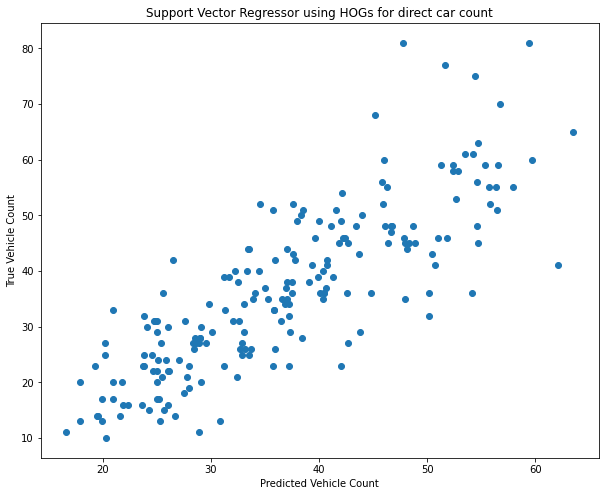

In [7]:

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(validPred, validCount)
ax.set_xlabel('Predicted Vehicle Count')
ax.set_ylabel('True Vehicle Count')
ax.set_title('Support Vector Regressor using HOGs for direct car count')
plt.show()

del fig, ax

In [8]:
r, p = stats.pearsonr(validPred, validCount)
print('Pearson’s Correlation Coefficient: ' + str(r))
del r, p

Pearson’s Correlation Coefficient: 0.8255004617311588


In [9]:
mae_sum = 0
mae_sum = np.sum(abs(validPred - validCount))
mae = mae_sum / len(validCount)
print('Mean Absolute Error: ' + str(mae))

del mae, mae_sum

Mean Absolute Error: 6.362325096623494


In [10]:
mse_sum = 0
mse_sum = np.sum((validPred - validCount)**2)
mse = mse_sum / len(validCount)

print('Mean Square Error: ' + str(mse))

del mse, mse_sum

Mean Square Error: 69.68214250507917


In [11]:
# Compute MDE Metric
def MDE (validPred, expected_counts):
  mean_ac = []
  true_vehicle_counts = validPred
  for i in range(len(true_vehicle_counts)):
    accuracy = (validPred[i]/expected_counts[i])*100
    ac = np.append(mean_ac, accuracy)
  # Compute mean of results
  return np.mean(ac)
print('Mean Deviation Error: ' + str(MDE(validPred, validCount))+ ' %')

TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
# Read Validation Traffic Image
testIm = []
csvTest = 'data/test.csv'
path = 'data/original/'

# read csv file for the testset
df = pd.read_csv(csvTest)
images = list(df['images'])

for image in images:
    im = color.rgb2gray(mpimg.imread(path + str(image), 0))
    testIm.append(im)

del path, image, df, csvTest, im

In [ ]:
hogTest = []

for x, im in enumerate(testIm):
    fd = myHog(im)
    hogTest.append(fd)

hogTest = np.stack(hogTest)
testPred = regr.predict(hogTest)

del x, fd, im

In [ ]:
out = [['images'], ['counts']]
out[0].extend(images)
out[1].extend(testPred.astype(int))

out2 = zip(*out)
out3 = list(out2)

with open('test_out1223.csv', 'w') as f:
    # using csv.writer method from CSV package
    write = csv.writer(f)
    for x in out3:
        write.writerow(x)
    f.close()

del write, out, out2, out3, x, f